# Interpretable AI Project

Saul Vassallo and David Scerri

In [27]:
# TensorFlow
import tensorflow as tf
from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Commonly used modules
import numpy as np

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython
from six.moves import urllib

print(tf.__version__)

2.18.0


## Boston Housing Model

Load the data

In [28]:
(boston_train_features, boston_train_labels), (boston_test_features, boston_test_labels) = keras.datasets.boston_housing.load_data()

print(boston_train_features.shape)
print(boston_test_features.shape)
print(boston_train_labels.shape)
print(boston_test_labels.shape)

(404, 13)
(102, 13)
(404,)
(102,)


Add the labels back to the dataset for feature engineering

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
  
- MEDV - Median value of owner-occupied homes in $1000's



In [41]:
boston_feature_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 
    'RM', 'AGE', 'DIS', 'RAD', 'TAX', 
    'PTRATIO', 'B', 'LSTAT'
]

boston_train_df = pd.DataFrame(boston_train_features, columns=boston_feature_names)
boston_test_df = pd.DataFrame(boston_test_features, columns=boston_feature_names)

print("Training Dataset Shape:", boston_train_df.shape)
print("\nFirst few rows of training data:")
print(boston_train_df.head())
print("\nDataset Info:")
print(boston_train_df.describe())

Training Dataset Shape: (404, 13)

First few rows of training data:
      CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS   RAD    TAX  \
0  1.23247   0.0   8.14   0.0  0.538  6.142   91.7  3.9769   4.0  307.0   
1  0.02177  82.5   2.03   0.0  0.415  7.610   15.7  6.2700   2.0  348.0   
2  4.89822   0.0  18.10   0.0  0.631  4.970  100.0  1.3325  24.0  666.0   
3  0.03961   0.0   5.19   0.0  0.515  6.037   34.5  5.9853   5.0  224.0   
4  3.69311   0.0  18.10   0.0  0.713  6.376   88.4  2.5671  24.0  666.0   

   PTRATIO       B  LSTAT  
0     21.0  396.90  18.72  
1     14.7  395.38   3.11  
2     20.2  375.52   3.26  
3     20.2  396.90   8.01  
4     20.2  391.43  14.65  

Dataset Info:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean     3.745111   11.480198   11.104431    0.061881    0.557356    6.267082   
std      9.240734   23.767711    6.811308    0.241238  

Scale non categorical inputs (RAD) and outputs using Z-Score

In [46]:
def z_score_scale(data, columns_to_scale=None, exclude_columns=None):
    """
    Scales columns using sklearn's StandardScaler. Can either specify columns to scale
    or columns to exclude from scaling.
    
    Args:
        data: pandas DataFrame containing the data
        columns_to_scale: list of column names to scale (optional)
        exclude_columns: list of column names to exclude from scaling (optional)
    
    Returns:
        DataFrame with scaled columns
    
    Note:
        If columns_to_scale is provided, exclude_columns is ignored.
        If neither is provided, all columns are scaled.
    """
    scaled_data = data.copy()
    
    # Determine which columns to scale
    if columns_to_scale is not None:
        # Use specified columns
        columns_to_process = columns_to_scale
    else:
        # Use all columns except excluded ones
        exclude_columns = exclude_columns or []
        columns_to_process = [col for col in data.columns if col not in exclude_columns]
    
    scaler = StandardScaler()
    scaled_data[columns_to_process] = scaler.fit_transform(data[columns_to_process])
    return scaled_data

boston_train_df = z_score_scale(boston_train_df, exclude_columns=['CHAS'])
boston_test_df = z_score_scale(boston_test_df, exclude_columns=['CHAS'])

scaler = StandardScaler()
boston_train_labels = scaler.fit_transform(boston_train_labels.reshape(-1, 1))
boston_test_labels = scaler.fit_transform(boston_test_labels.reshape(-1, 1))

print(boston_train_df.head())
print(boston_test_df.head())


       CRIM        ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0 -0.272246 -0.483615 -0.435762   0.0 -0.165227 -0.176443  0.813062  0.116698   
1 -0.403427  2.991784 -1.333912   0.0 -1.215182  1.894346 -1.910361  1.247585   
2  0.124940 -0.483615  1.028326   0.0  0.628642 -1.829688  1.110488 -1.187439   
3 -0.401494 -0.483615 -0.869402   0.0 -0.361560 -0.324558 -1.236672  1.107180   
4 -0.005634 -0.483615  1.028326   0.0  1.328612  0.153642  0.694808 -0.578572   

        RAD       TAX   PTRATIO         B     LSTAT  
0 -0.626249 -0.595170  1.148500  0.448077  0.825220  
1 -0.856463 -0.348433 -1.718189  0.431906 -1.329202  
2  1.675886  1.565287  0.784476  0.220617 -1.308500  
3 -0.511142 -1.094663  0.784476  0.448077 -0.652926  
4  1.675886  1.565287  0.784476  0.389882  0.263497  
       CRIM        ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0  2.804030 -0.507849  0.969609   0.0  1.231746  0.119341  1.147398 -0.919353   
1 -0.555306 -0.507849 -0.17

Epoch 1/10000


/Users/saulvassallo/Documents/ARI3205-Interpretable-AI/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2816 - mae: 0.8609 - mse: 1.2816 - val_loss: 0.3589 - val_mae: 0.4989 - val_mse: 0.3589
Epoch 2/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8884 - mae: 0.6870 - mse: 0.8884 - val_loss: 0.2695 - val_mae: 0.4018 - val_mse: 0.2695
Epoch 3/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5492 - mae: 0.5359 - mse: 0.5492 - val_loss: 0.2332 - val_mae: 0.3670 - val_mse: 0.2332
Epoch 4/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5478 - mae: 0.5260 - mse: 0.5478 - val_loss: 0.2438 - val_mae: 0.3792 - val_mse: 0.2438
Epoch 5/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4980 - mae: 0.5032 - mse: 0.4980 - val_loss: 0.2486 - val_mae: 0.3864 - val_mse: 0.2486
Epoch 6/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5038 - mae: 0.4915 - mse: 0.5038 - val_loss: 0.2539 - val_mae: 0.3871 - val_mse: 0.2539
Epoch 7/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4284 - mae: 0.4681 - mse: 0.4284 - val_loss: 

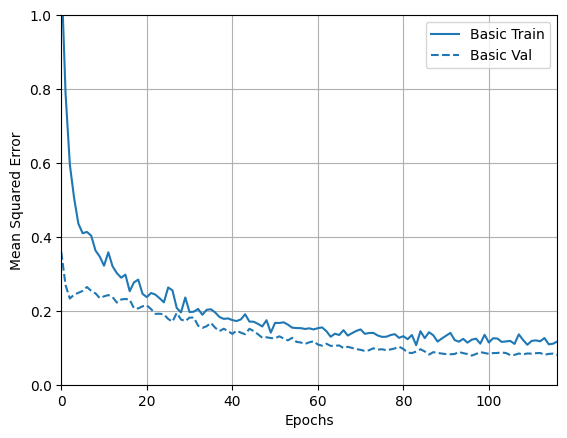

In [50]:
boston_model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(13,)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

boston_model.compile(optimizer='adam',
                     loss='mse',
                     metrics=['mse', 'mae'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = boston_model.fit(boston_train_df, boston_train_labels, epochs=10000, validation_split=0.1, callbacks=[early_stop])

plotter = tfdocs.plots.HistoryPlotter(metric = 'mse')
plotter.plot({'Basic': history}, metric = 'mse')
plt.ylim([0, 1])
plt.ylabel('Mean Squared Error')
plt.show()


## Titanic Model

load data and check nu of nas and na percentages


In [30]:
titanic_train_data = pd.read_csv('data/titanic/train.csv')
titanic_test_data = pd.read_csv('data/titanic/test.csv')

print(titanic_train_data.shape)
print(titanic_test_data.shape)

# Check NA values in training data
print("NA values in training data:")
print(titanic_train_data.isna().sum())

print("\nNA values in test data:")
print(titanic_test_data.isna().sum())

# Percentage of NA values in training data
print("\nPercentage of NA values in training data:")
print((titanic_train_data.isna().sum() / len(titanic_train_data)) * 100)

print("\nPercentage of NA values in test data:")
print((titanic_test_data.isna().sum() / len(titanic_test_data)) * 100)

print(titanic_train_data.head())
print(titanic_test_data.head())


(891, 12)
(418, 11)
NA values in training data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

NA values in test data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Percentage of NA values in training data:
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Percentage of NA values in test data:
PassengerId     0.000000
Pclass          0.000000
Name            0

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Drop non-numerical columns

In [31]:
# Feature engineering

# Drop unnecessary columns
titanic_train_data = titanic_train_data.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])
titanic_test_data = titanic_test_data.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])

print(titanic_train_data.head())
print(titanic_test_data.head())


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


Encode categorical columns

In [32]:
def encode_features(data):
    mappings = {}
    for column in data.columns:
        if data[column].dtype == 'object':
            le = LabelEncoder()
            data[column] = le.fit_transform(data[column])
            # Store the mapping
            mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))
            print(f"\nMapping for {column}:")
            for original, encoded in mappings[column].items():
                print(f"{original} → {encoded}")
    return data

titanic_train_data = encode_features(titanic_train_data)
titanic_test_data = encode_features(titanic_test_data)


print(titanic_train_data.head())
print(titanic_test_data.head())


Mapping for Sex:
female → 0
male → 1

Mapping for Embarked:
C → 0
Q → 1
S → 2
nan → 3

Mapping for Sex:
female → 0
male → 1

Mapping for Embarked:
C → 0
Q → 1
S → 2


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2


Deal with NA values by replacing them with their means and dropping the 2 in embarked col

In [51]:
titanic_train_data = titanic_train_data[titanic_train_data['Embarked'] != 3]

titanic_train_data = titanic_train_data.fillna(titanic_train_data.mean())
titanic_test_data = titanic_test_data.fillna(titanic_test_data.mean())

Scale non-categorical values using z-score

In [37]:
titanic_train_data = z_score_scale(titanic_train_data, ['Age', 'Fare', 'SibSp', 'Parch'])
titanic_test_data = z_score_scale(titanic_test_data, ['Age', 'Fare', 'SibSp', 'Parch'])

print(titanic_train_data.head())
print(titanic_test_data.head())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,0.334993,-0.499470,-0.400248,-0.498407,1.0
1,3,0,1.325530,0.616992,-0.400248,-0.513274,2.0
2,2,1,2.514175,-0.499470,-0.400248,-0.465088,1.0
3,3,1,-0.259330,-0.499470,-0.400248,-0.483466,2.0
4,3,0,-0.655545,0.616992,0.619896,-0.418471,2.0


Separate labels and features for training

In [38]:
titanic_train_features = titanic_train_data.drop(columns=['Survived'])
titanic_train_labels = titanic_train_data['Survived']

titanic_test_features = titanic_test_data

Train the Model

Epoch 1/10000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6363 - loss: 0.6882 - val_accuracy: 0.6222 - val_loss: 0.6289
Epoch 2/10000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6344 - loss: 0.6612 - val_accuracy: 0.6222 - val_loss: 0.5967
Epoch 3/10000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6655 - loss: 0.6046 - val_accuracy: 0.6333 - val_loss: 0.5787
Epoch 4/10000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6673 - loss: 0.6065 - val_accuracy: 0.6778 - val_loss: 0.5637
Epoch 5/10000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6797 - loss: 0.5884 - val_accuracy: 0.6778 - val_loss: 0.5492
Epoch 6/10000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6818 - loss: 0.5895 - val_accuracy: 0.7222 - val_loss: 0.5380
Epoch 7/10000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6937 - loss: 0.5761 - val_accuracy: 0.7556 - val_loss: 0.5284
Epoch 8/10000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6907 - loss: 0.5708 - val_accu

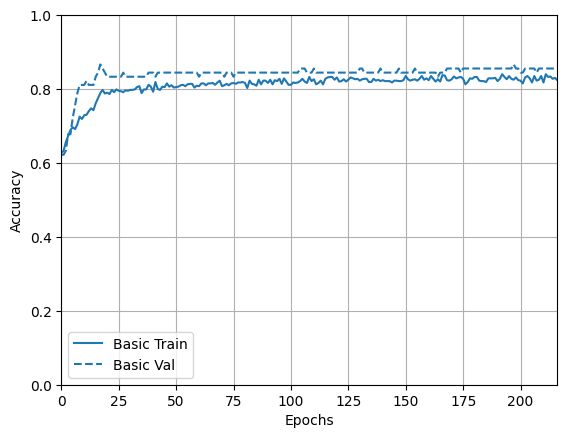

In [52]:
titanic_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

titanic_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

history = titanic_model.fit(titanic_train_features, titanic_train_labels, epochs=10000, validation_split=0.1, callbacks=[early_stop])

plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot({'Basic': history}, metric = 'accuracy')
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.show()